# Practical 2: More flexibility with magic factory

In Practical 1, we learned how to implement a simple thresholding widget with the `@magicgui` decorator. Here, we will learn how to create widgets with more flexibility using the `@magic_factory` decorator

## Load sample data

In [2]:
from skimage import data

nuclei_img = data.cells3d()[30,1]

## Cell segmentation

We will now extend our `threshold_image` function to create a widget that enables users to select between different cell segmentation methods. We also want to allow users to modify parameters of each of the selected segmentation algorithm. 

We will consider three segmentation algorithms:
1) Simple thresholding 
2) [Otsu thresholding](https://scikit-image.org/docs/stable/api/skimage.filters.html#skimage.filters.threshold_otsu)
3) [Cellpose](https://cellpose.readthedocs.io/en/latest/)

- For more information: [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method), [Cellpose](https://www.nature.com/articles/s41592-020-01018-x)

### Simple Thresholding

We will re-use the `threshold_image` function from Practical 1.

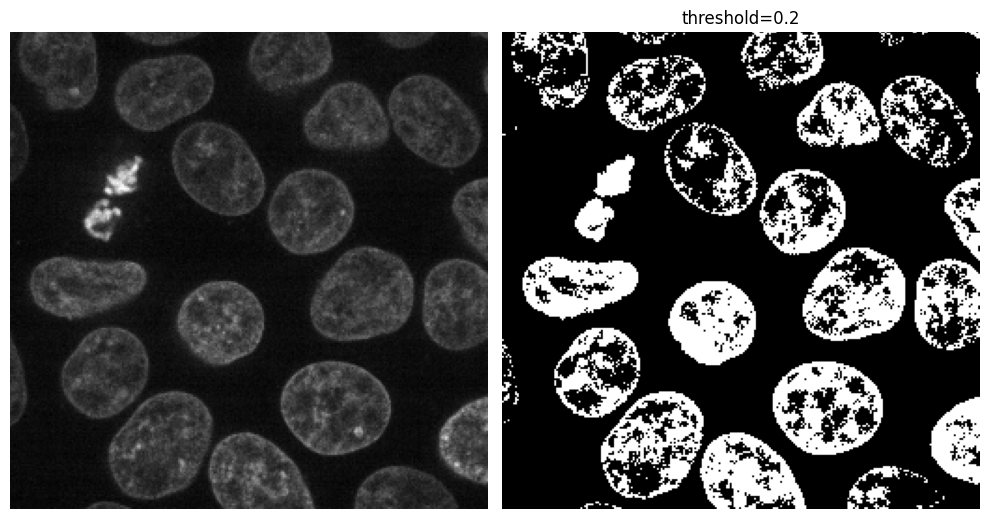

In [4]:
import numpy as np 
from skimage.util import img_as_float
import matplotlib.pyplot as plt

def threshold_image(input_img: np.ndarray, threshold: float) -> np.ndarray:
    # Convert to float
    img = img_as_float(input_img)
    # Apply threshold
    thresh_img = img > threshold
    
    return thresh_img

# Define a threshold value
threshold = 0.2

# Obtain results from thresholding function
thresh_img = threshold_image(nuclei_img, threshold)

# Show image and thresholding result side-by-side
fig, ax = plt.subplots(1, 2, figsize=(10,20))
ax[0].imshow(nuclei_img, cmap='gray')
ax[0].axis('off')
ax[1].imshow(thresh_img, cmap='gray')
ax[1].axis('off')
ax[1].set_title(f'threshold={threshold}')
fig.tight_layout()
plt.show()

### Otsu Thresholding

We will now define the function `apply_threshold_otsu` and verify that it works.

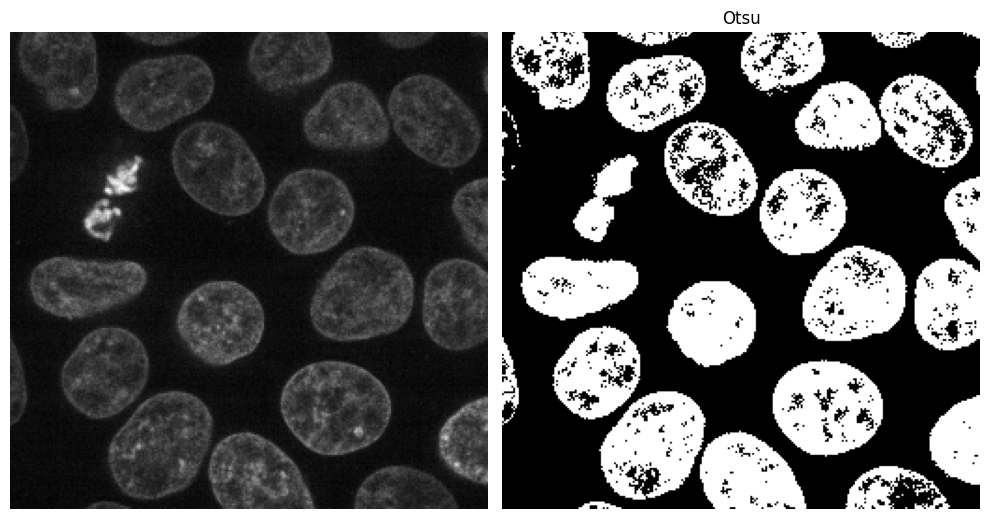

In [5]:
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

def apply_threshold_otsu(input_img: np.ndarray, nbins: int=256) -> np.ndarray:
    # Convert to float
    img = img_as_float(input_img)
    # Obtain upper threshold value for each pixel
    threshold = threshold_otsu(img, nbins=nbins)
    # Apply thrshold
    thresh_img = img > threshold

    return thresh_img

# Obtain results from thresholding function
thresh_img = apply_threshold_otsu(nuclei_img)

# Show image and thresholding result side-by-side
fig, ax = plt.subplots(1, 2, figsize=(10,20))
ax[0].imshow(nuclei_img, cmap='gray')
ax[0].axis('off')
ax[1].imshow(thresh_img, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Otsu')
fig.tight_layout()
plt.show()

### Cellpose

Now, we will define the function `apply_cellpose` and verify that it works.

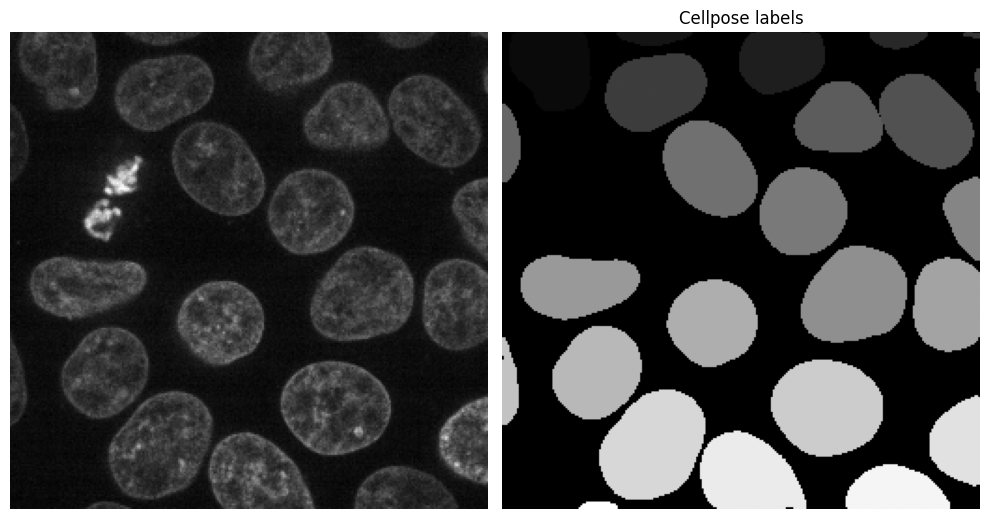

In [7]:
from cellpose import models 

def apply_cellpose(input_img: np.ndarray, use_gpu: bool=True) -> np.ndarray:
    # Convert to float
    img = img_as_float(input_img)

    # Instantiate Cellpose model
    model = models.CellposeModel(gpu=use_gpu)

    # Obtain Cellpose labels
    labels, __, __ = model.eval(img)

    return labels 

# Obtain Cellpose labels
thresh_img = apply_cellpose(nuclei_img)

# Show image and thresholding result side-by-side
fig, ax = plt.subplots(1, 2, figsize=(10,20))
ax[0].imshow(nuclei_img, cmap='gray')
ax[0].axis('off')
ax[1].imshow(thresh_img, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Cellpose labels')
fig.tight_layout()
plt.show()

### Defining the segmentation function

Now we are ready to combine the three segmentation algorithms into one segmentation function `segment_image` that accepts `napari.layers.Image` as input and returns `napari.layers.Labels`. Recall that the underlying image array can be accessed with `.data`. We also have to pass the parameters for each segmentation function that we defined earlier and choose the desired segmentation algorithm.

In [8]:
from napari.layers import Image, Labels

def segment_image(   
    input_img: Image,
    algorithm: str,
    threshold: float=0.2,
    nbins: int=256,
    use_gpu: bool=True
) -> Labels:

    if algorithm == 'Threshold':
        labels = threshold_image(input_img=input_img.data, 
                                 threshold=threshold)
    elif algorithm == 'Otsu':
        labels = apply_threshold_otsu(input_img=input_img.data,
                                      nbins=nbins)
    elif algorithm == 'Cellpose':
        labels = apply_cellpose(input_img=input_img.data,
                                use_gpu=use_gpu)

    return Labels(labels, name=f'{input_img.name}_{algorithm}')

We will now verify that the `segment_image` function works.

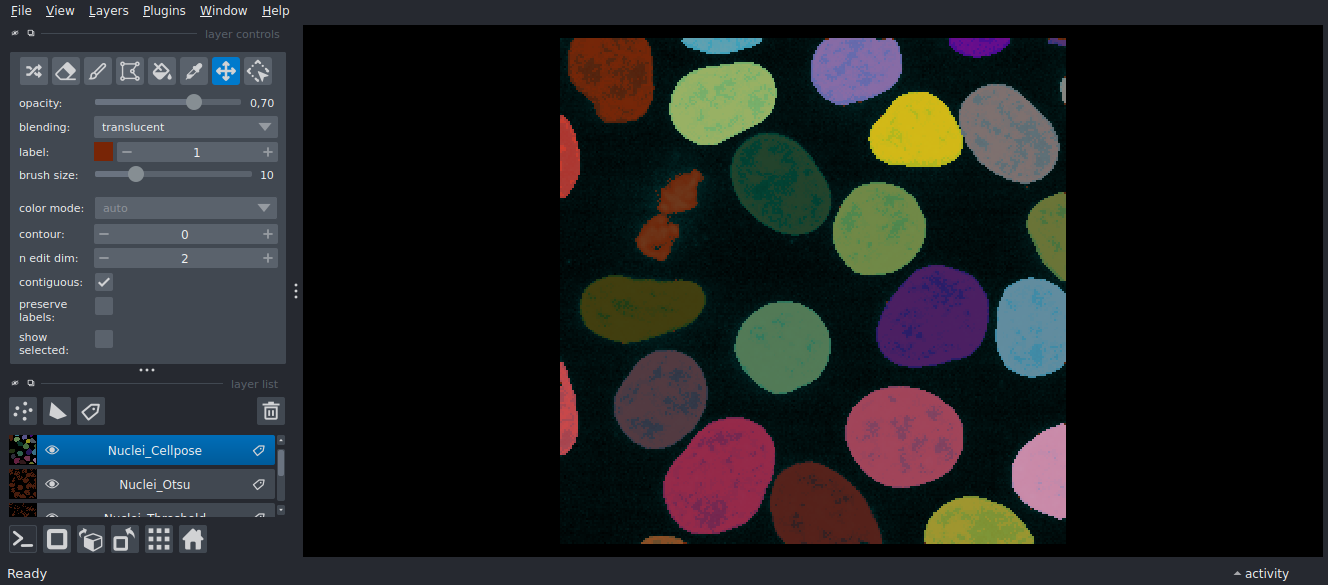

In [11]:
import napari 

nuclei_img_layer = Image(nuclei_img, name='Nuclei', colormap='cyan')

thresh_layer = segment_image(nuclei_img_layer, algorithm='Threshold')
otsu_layer = segment_image(nuclei_img_layer, algorithm='Otsu')
cellpose_layer = segment_image(nuclei_img_layer, algorithm='Cellpose')

viewer = napari.Viewer()
viewer.add_layer(nuclei_img_layer)
viewer.add_layer(thresh_layer)
viewer.add_layer(otsu_layer)
viewer.add_layer(cellpose_layer)
napari.utils.nbscreenshot(viewer)

## Making a widget from our function with `magic_factory` 

We will now make a widget using the `magic_factory` decorator. The layout of the widget is specified with `layout` and the label of the button by `call_button`. For each parameter, we will pass `kwargs` which define the appearance and default values. 

From now on, we will avoid imports by using forward references - instead of importing napari types, we will specify them as strings (e.g. `Image` becomes `'napari.layers.Image'`). We also get direct access to the napari viewer by passing the type hint `'napari.viewer.Viewer'` to the `viewer` parameter. We will use this to explicitly add the `Labels` layer to the viewer with `viewer.add_layer()`.

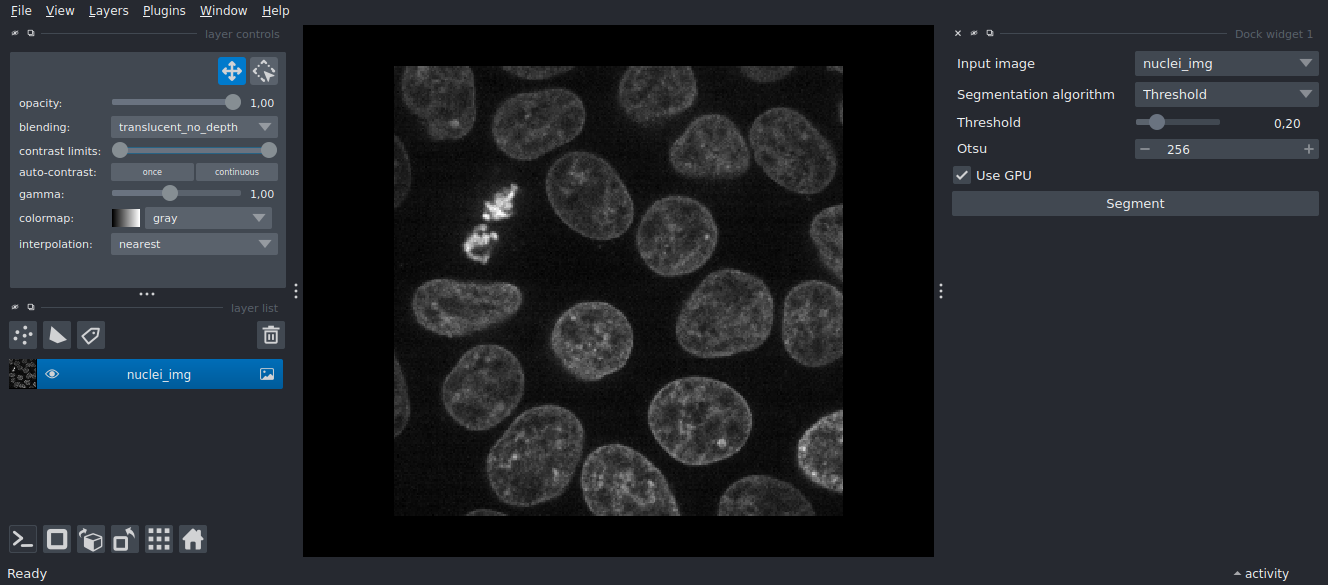

In [12]:
from magicgui import magic_factory

@magic_factory(
    layout='vertical', call_button='Segment',
    input_img={'label': 'Input image'},
    algorithm={'label': 'Segmentation algorithm',
               'widget_type': 'ComboBox',
               'choices': ['Threshold', 'Otsu', 'Cellpose'],
               'value': 'Threshold'},
    threshold={'label': 'Threshold',
               'widget_type': 'FloatSlider',
               'min': 0, 'max': 1, 'value': 0.2},
    nbins={'label': 'Otsu',
           'widget_type': 'SpinBox',
           'min': 0, 'value': 256},
    use_gpu={'label': 'Use GPU',
             'widget_type': 'CheckBox',
             'value': True}
)
def segment_image_widget(
    viewer: 'napari.viewer.Viewer',
    input_img: 'napari.layers.Image',
    algorithm: str,
    threshold: float,
    nbins: int, 
    use_gpu: bool
):
    labels = segment_image(input_img=input_img,
                           algorithm=algorithm,
                           threshold=threshold,
                           nbins=nbins,
                           use_gpu=use_gpu)

    # Add Labels layer to viewer
    viewer.add_layer(labels)
    
viewer = napari.view_image(nuclei_img)
# Instantiate widget
widget = segment_image_widget()
# Add widget
viewer.window.add_dock_widget(widget)
napari.utils.nbscreenshot(viewer)

### Modifying widget behaviour with `widget_init`

In the previous widget, all parameters showed up even if they were not relevant for the selected algorithm. Here, we will change this by using the `widget_init` parameter. We will define the function `on_init` to only show relevant properties. 

#### Define the `on_init` function

The `on_init` function defines the initialisation of our plugin and can be used to connect events (e.g. a button click or a changed selection in a `ComboBox`). We begin by initialising parameter visibility:

```python
def on_init(widget):
    threshold_properties = ['threshold']
    otsu_properties = ['nbins']
    cellpose_properties = ['use_gpu']

    # Initialise widget layout
    for x in threshold_properties:
        setattr(getattr(widget, x), 'visible', True)
    for x in otsu_properties + cellpose_properties:
        setattr(getattr(widget, x), 'visible', False)
```

Next, we define the function `toggle_visibility` to change parameter visibility based on the selected segmentation algorithm:
```python
    def toggle_visibility(algorithm: str):
        if algorithm == 'Threshold':
            for x in threshold_properties:
                setattr(getattr(widget, x), 'visible', True)
            for x in otsu_properties + cellpose_properties:
                setattr(getattr(widget, x), 'visible', False)

        elif algorithm == 'Otsu':
            for x in otsu_properties:
                setattr(getattr(widget, x), 'visible', True)
            for x in threshold_properties + cellpose_properties:
                setattr(getattr(widget, x), 'visible', False)     

        elif algorithm == 'Cellpose':
            for x in cellpose_properties:
                setattr(getattr(widget, x), 'visible', True)
            for x in threshold_properties + otsu_properties:
                setattr(getattr(widget, x), 'visible', False)    
```

Finally, we need to connect our `algorithm` widget to the `toggle_visibility` function:
```python 
    # Connect toggle_visibility to chosen algorithm
    widget.algorithm.changed.connect(toggle_visibility)
```

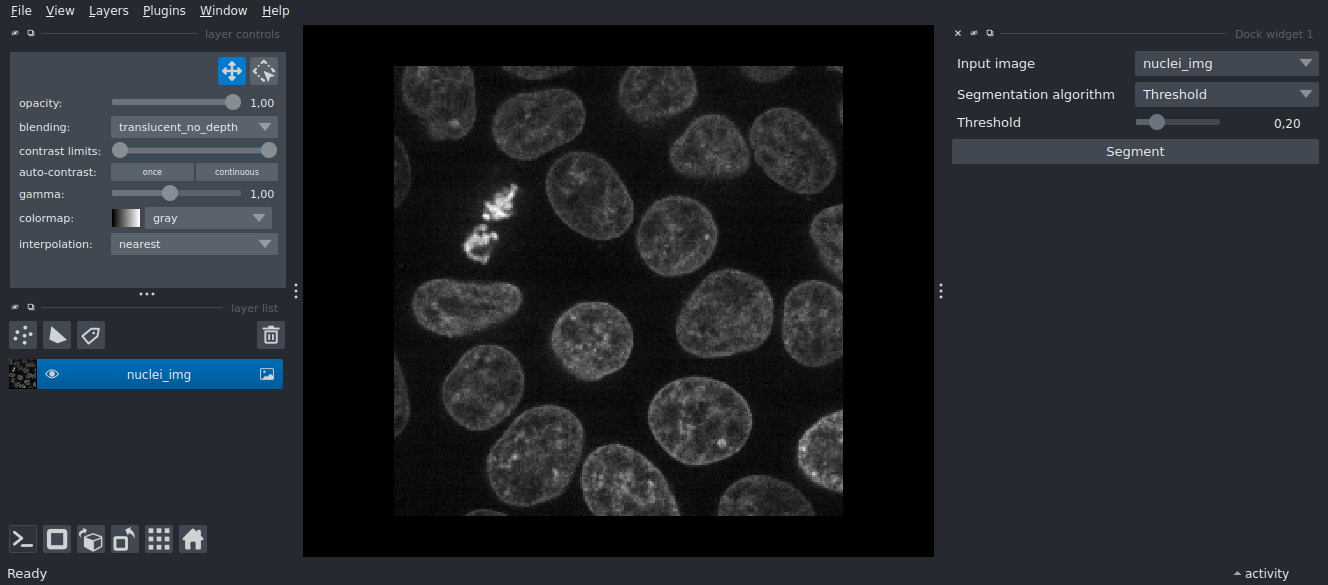

In [18]:
def on_init(widget):
    threshold_properties = ['threshold']
    otsu_properties = ['nbins']
    cellpose_properties = ['use_gpu']

    # Initialise widget layout
    for x in threshold_properties:
        setattr(getattr(widget, x), 'visible', True)
    for x in otsu_properties + cellpose_properties:
        setattr(getattr(widget, x), 'visible', False)

    # Change property visibility based on the selected algorithm
    def toggle_visibility(algorithm: str):
        if algorithm == 'Threshold':
            for x in threshold_properties:
                setattr(getattr(widget, x), 'visible', True)
            for x in otsu_properties + cellpose_properties:
                setattr(getattr(widget, x), 'visible', False)

        elif algorithm == 'Otsu':
            for x in otsu_properties:
                setattr(getattr(widget, x), 'visible', True)
            for x in threshold_properties + cellpose_properties:
                setattr(getattr(widget, x), 'visible', False)     

        elif algorithm == 'Cellpose':
            for x in cellpose_properties:
                setattr(getattr(widget, x), 'visible', True)
            for x in threshold_properties + otsu_properties:
                setattr(getattr(widget, x), 'visible', False)          

    # Connect toggle_visibility to chosen algorithm
    widget.algorithm.changed.connect(toggle_visibility)

    
@magic_factory(
    widget_init=on_init, layout='vertical', call_button='Segment',
    input_img={'label': 'Input image'},
    algorithm={'label': 'Segmentation algorithm',
               'widget_type': 'ComboBox',
               'choices': ['Threshold', 'Otsu', 'Cellpose'],
               'value': 'Threshold'},
    threshold={'label': 'Threshold',
               'widget_type': 'FloatSlider',
               'min': 0, 'max': 1, 'value': 0.2},
    nbins={'label': 'Otsu',
           'widget_type': 'SpinBox',
           'min': 0, 'value': 256},
    use_gpu={'label': 'Use GPU',
             'widget_type': 'CheckBox',
             'value': True}
)
def segment_image_widget(
    viewer: 'napari.viewer.Viewer',
    input_img: 'napari.layers.Image',
    algorithm: str,
    threshold: float,
    nbins: int, 
    use_gpu: bool
):
    labels = segment_image(input_img=input_img,
                           algorithm=algorithm,
                           threshold=threshold,
                           nbins=nbins,
                           use_gpu=use_gpu)

    # Add Labels layer to viewer
    viewer.add_layer(labels)
    
viewer = napari.view_image(nuclei_img)
# Instantiate widget
widget = segment_image_widget()
# Add widget
viewer.window.add_dock_widget(widget)
napari.utils.nbscreenshot(viewer)

### Avoiding napari from freezing with `thread_worker`

The napari viewer runs within an event loop. If a long running function is launched, this will block the viewer from updating and it may freeze. To avoid this from happening, we will make use of multithreading to run our function in a spearate thread. We will achieve this by using the `@thread_worker` decorator. We will define the function `_add_labels` to handle the result from our `thread_worker`. We also need to define a wrapper function `_segment_image` for our `segment_image` function and add the `@thread_worker` decorator.

- For more information: [Napari event loop](https://napari.org/0.5.6/guides/event_loop.html), [Multithreading in napari](https://napari.org/0.5.6/guides/threading.html)

#### Define wrapper function

Since we are reusing the previously defined `segment_image` function, we need to define a wrapper function `_segment_image` which we can decorate with `@thread_worker`: 
```python 
@thread_worker
def _segment_image(input_img, algorithm, threshold, nbins, use_gpu):
    labels = segment_image(input_img=input_img,
                           algorithm=algorithm,
                           threshold=threshold,
                           nbins=nbins,
                           use_gpu=use_gpu)
    return labels
```

#### Start worker

The `@thread_worker` decorator converts our function `_segment_image` to return a `worker`. Once it finishes running, it will emit a `returned` signal. To retrieve the returned data, we need to connect our `worker` to a function (see below) that handles the output. To start our worker, we need to call `.start()`:
```python 
worker = _segment_image(input_img=input_img,
                        algorithm=algorithm,
                        threshold=threshold,
                        nbins=nbins,
                        use_gpu=use_gpu)
worker.returned.connect(_add_labels)
worker.start()
    
```

#### Handle worker results 

To add the returned data from our `worker` to the napari viewer, we use the `_add_labels` function:

```python 
def _add_labels(labels):
    viewer.add_layer(labels)
```

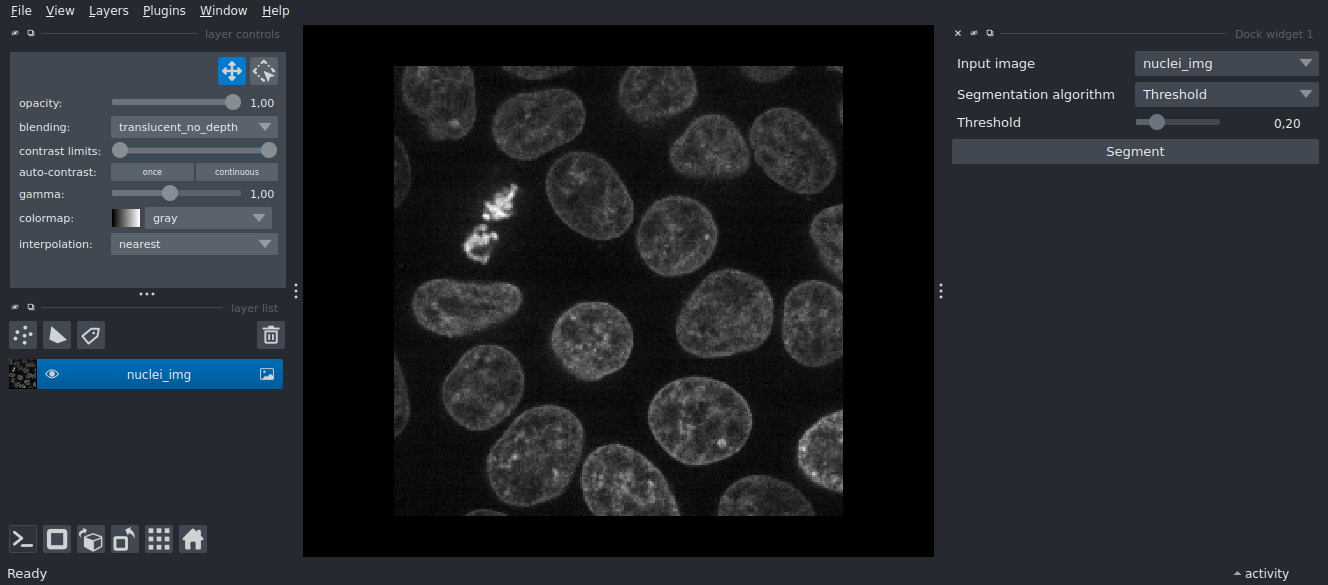

In [19]:
def on_init(widget):
    threshold_properties = ['threshold']
    otsu_properties = ['nbins']
    cellpose_properties = ['use_gpu']

    # Initialise widget layout
    for x in threshold_properties:
        setattr(getattr(widget, x), 'visible', True)
    for x in otsu_properties + cellpose_properties:
        setattr(getattr(widget, x), 'visible', False)

    # Change property visibility based on the selected algorithm
    def toggle_visibility(algorithm: str):
        if algorithm == 'Threshold':
            for x in threshold_properties:
                setattr(getattr(widget, x), 'visible', True)
            for x in otsu_properties + cellpose_properties:
                setattr(getattr(widget, x), 'visible', False)

        elif algorithm == 'Otsu':
            for x in otsu_properties:
                setattr(getattr(widget, x), 'visible', True)
            for x in threshold_properties + cellpose_properties:
                setattr(getattr(widget, x), 'visible', False)     

        elif algorithm == 'Cellpose':
            for x in cellpose_properties:
                setattr(getattr(widget, x), 'visible', True)
            for x in threshold_properties + otsu_properties:
                setattr(getattr(widget, x), 'visible', False)          

    # Connect toggle_visibility to chosen algorithm
    widget.algorithm.changed.connect(toggle_visibility)

    
@magic_factory(
    widget_init=on_init, layout='vertical', call_button='Segment',
    input_img={'label': 'Input image'},
    algorithm={'label': 'Segmentation algorithm',
               'widget_type': 'ComboBox',
               'choices': ['Threshold', 'Otsu', 'Cellpose'],
               'value': 'Threshold'},
    threshold={'label': 'Threshold',
               'widget_type': 'FloatSlider',
               'min': 0, 'max': 1, 'value': 0.2},
    nbins={'label': 'Otsu',
           'widget_type': 'SpinBox',
           'min': 0, 'value': 256},
    use_gpu={'label': 'Use GPU',
             'widget_type': 'CheckBox',
             'value': True}
)
def segment_image_widget(
    viewer: 'napari.viewer.Viewer',
    input_img: 'napari.layers.Image',
    algorithm: str,
    threshold: float,
    nbins: int, 
    use_gpu: bool
):
    # Import thread_worker 
    from napari.qt.threading import thread_worker

    # Handle thread_worker output
    def _add_labels(labels):
        viewer.add_layer(labels)

    @thread_worker
    def _segment_image(input_img, algorithm, threshold, nbins, use_gpu):
        labels = segment_image(input_img=input_img,
                               algorithm=algorithm,
                               threshold=threshold,
                               nbins=nbins,
                               use_gpu=use_gpu)
        return labels

    worker = _segment_image(input_img=input_img,
                            algorithm=algorithm,
                            threshold=threshold,
                            nbins=nbins,
                            use_gpu=use_gpu)
    worker.returned.connect(_add_labels)
    worker.start()
    
viewer = napari.view_image(nuclei_img)
# Instantiate widget
widget = segment_image_widget()
# Add widget
viewer.window.add_dock_widget(widget)
napari.utils.nbscreenshot(viewer)